# Overview

*Goal*: To explore different modeling choices that interpret Colorado's constitutional language of political competitiveness.

*Motivation*: “Thereafter, the commission shall, to the extent possible, maximize the number of politically competitive districts… ‘competitive’ means having a reasonable potential for the party affiliation of the district’s representative to change at least once between federal decennial censuses. 

Competitiveness may be measured by factors such as a proposed district’s past election results, a proposed district’s political party registration data, and evidence-based analyses of proposed districts.” - [Congressional Language (Section 44.3)](https://redistricting.colorado.gov/content/redistricting-laws) 

# Colorado Context and Background

<img src="https://uwescience.github.io/DSSG2021-redistricting-website/assets/img/co_criteria.png" width=300 height=300/>

Colorado’s requirements for the redistricting of Congressional districts is established in state constitutional provisions that outline the composition of the Colorado’s Independent Congressional Redistricting Commission and the requirements for the redrawing of district boundaries. There are six core requirements for a proposed redistricting plan, organized along a hierarchy of priority:
- Equal population
- Comply with Voting Rights Act (VRA) of 1965
- Contiguous 
- Preserve whole communities of interest
- Preserve whole political subdivisions
- Keep districts compact

Redistricting rules require the first three requirements to be satisified before moving onto the last three requirements. Only after all six requirements are satisifed should political competitive districts be considered.

Some rules are more difficult to quantify in GerryChain compared to others. 

- *Equal population*: Population balance is pretty straight forward to quantify, since it’s just the total state population divided by the number of districts. We will only accept maps that satisfy this requirement
- *Comply with VRA*: VRA compliance requires thoughtful modeling and decision making. Specifically, the VRA states that district plans may not “discriminate on the basis of race, color or membership in a language minority group.” This is where decision trees start to emerge. What  voting age population should be prioritized? Is it possible to integrate consideration for all populations within one proposed map? Colorado has ~25% voters of color, but that ~25% is composed of 6 different racial groups scattered across the state. The landscape of VRA compliance looks much different in Colorado compared to other states, such as [Texas](https://uwescience.github.io/DSSG2021-redistricting-website/texas/) which has seen specific types of racial demographic growth and presents conditions for minority opportunity districts to be drawn. To best examine compliance with the VRA in Colorado, our analysis tracks person of color voting age population per district for all proposed plans.
- *Contiguous*: All proposed district maps must have contiguous districts, where districts share a common border. GerryChain include [constraint functions for contiguity](https://gerrychain.readthedocs.io/en/latest/_modules/gerrychain/constraints/contiguity.html), therefore making contiguity a relatively easy requirement to uphold in the code. 

After the three rules are satisfied, then the next three rules can be addressed.

- *Communities of interest*: This rule describe communities of shared interest that should be kept together. This criterion is qualitative in nature, which GerryChain cannot implement, and the rule itself contains conflicting interpretations. The human and political element behind this rule is necessary to draw maps that best reflect communities of interest. Colorado endevours to do this by having [open hearings](https://redistricting.colorado.gov/content/meeting-summaries) that the public can attend to present their views of communities of interest. Other cities, such as Chicago, have community organizational efforts that work to have residents specifically draw maps that they view reflect their communities of interest. The public can then present their drawn maps in open testimony to be considered for adoption (see, [Chicago Advisory Redistricting Commission](https://chicagoswards.org) for more details).
- *Preserve whole political subdivisions*: The preservation of political lines is a key modeling decision that GerryChain can adopt.  We can keep track of political units, such as counties, cities, school district, and water districts, and coerce the walk to only accept specific conditions, such as one that minimizes number of county splits in a given plan. However, it would be very difficult to preserve all political lines as boundaries may conflict with each other – for example, water districts cutting across multiple cities. Therefore, a decision has to be made about which political boundary is retained. The analysis presented here focuses on county preservation, as it is a key political subdivision that the current redistricting commission considers when drawing maps. 
- *Compactness*: Compactness measures examine the shape of districts, specifically the "compactness of a district is a geometric quantity intended to capture how “contorted” or “oddly shaped” a district is" (Barnes & Solomon, 2020, p. 2). However, compactness measures are problematic and complicated in implementation due to confounding factors of "geography, topography, cartographic projections, and resolution" (Barnes & Solomon, p. 2). Compactness scores suffer from degrees of ambiguity and its ability to be gamed. We elected not to address compactness in this analysis (besides a basic quanitative application as detailed later in the code) due to the complex decision tree and trade-offs associated with this rule, our project's limited timeline, and our intended focus on political competitiveness. To supply additional context, we have summarized what a modeler should consider about compactness measures as detailed by Barnes and Solomon.

### A brief discussion about compactness

Barnes, R., & Solomon, J. (2020). Gerrymandering and compactness: Implementation flexibility and abuse. *Political Analysis,* 1-19.

Barnes and Solomon identified 9 factors that describe the complications behind the use of compactness measures.

(1) *Choice of mathematical definition*: 24 different measures in the literature; 3 most widely used listed below, each with a range of [0, 1] with higher values indicating greater compactness and lower values indicating potential gerrymandering:

- Polsby-Popper: Given as 4πA/P2 where A is the area of a district and P its perimeter, also known as the “isoperimetric ratio".

- Reock: The ratio of a district’s area to the area of its minimum bounding circle

- Convex Hull: The ratio of a district’s area to the area of its convex hull, the minimum convex shape that completely contains the district

(2) *Contiguity*: There's no federal requirement that districts must be contiguous and compactness measures assume contiguity. While there are ways to incorporate non-contiguity into compactness sores, each has a large effect. Polsby-Popper contain formula extensions to accommodate non-contiguity. 

(3) *Topological holes*: Compactness scores make assumptions that districts are made up of a singular planar polygon; neglecting complications with islands (and their naturally shaped boundaries), and holes that are naturally occurring  (e.g., lakes, ponds) or exist for historical reasons (e.g., town annexation)

(4) *Boundaries of political superunits*: Compactness scores do not account for the placement and position of political jurisdictional boundaries (e.g., town, county lines) and natural boundaries such as coastlines. Boundary data do not always align, authors recommend using data that co-align (e.g., U.S. Census data).

Scores can be updated to accommodate political boundaries. For Convex hull and Reock scores, the hull or minimum bounding circle can be intersected with a state polygon which results in "a better representation of what was possible and, therefore, a better indicator of whether gerrymandering took place" (Barnes & Solomon, p. 7).

(5) *Map projection*: The Earth is not flat and map projects should accommodate the curvature of a sphere to avoid distortion. This is usually not an issue (when "reasonable choices among localized (country-scale) map projections used in practice" (Barnes & Solomon, p. 10)), but states such as Alaska can pose a challenge (difference up to 20% between a projection of conterminous United States and an Alaska-specific projection). The use of global maps can also lead to distortions.

(6) *Topography*: Maps with topographical information and non-topographical information matter. Authors calculated in Polsby–Popper scores between the topographic and non- topographic data with results indicating less than 0.03 difference for all districts, with 75% of districts having deviations less than 0.005.

(7) *Data resolution*: Resolution can be defined as "density of points describing a boundary" (p. 11) and resolution matters for compactness scores. Lower resolution lead to simpler shapes often with shorter perimeters and choice of data resolution impacts compactness score calculations, particularily the Polsby-Popper score. Authors recommend avoiding low-resolution data, even when doing so sacrifices benefits in computational time.

(8) *Floating-point calculations*: 32-bit single-precision type contain 7 decimal places of precision while 64-bit double-precision type provide about 15 decimal places of precision. Authors recommend using 64-bit IEE754 compliant types as the “true” value, as 32-bit types can potentially give erroneous results.

(9) *Whether alternative choices were possible in drawing a district’s boundaries*

# Data Selection  

*Decision Point*: Is the data sufficient for the analyses I want to run?

The Colorado case study utilizes a processed shapefile of [2018 precinct-level election results](https://github.com/mggg-states/CO-shapefiles). More details on MGGG’s Colorado data source and process can be found [here](https://github.com/mggg-states/CO-shapefiles). The shapefile contains one federal election (U.S. House race) and four state-level races, as well as racial demographic data for the population and voting age population of the precinct.

*Limitations*: Due to raw data quality initially supplied to MGGG from the Colorado State Demographer's Office and the need for extended processing, 81% (n= 2555) of the precincts in the final shapefile do have have a state-wide 10-digit unique precinct ID. This made joining MGGG’s shapefile with other precinct-level data tricky since only 19% of the IDs matched upon a simple merge. Higher-level unique IDs, such as Voting District, are available, but aggregating up would lose precinct-level distinctions. 

Additionally, Colorado's precinct boundaries change annually due to shifting population totals, so while Congressional district boundaries remained the same from 2012-2022, there have been slight shifts of precinct lines over the years. There is currently a lack of publically available, clean data that keeps track of precinct changes over time and election results tracked across the years.

Therefore, only 2018 election data attached to the preprocessed MGGG shapefile will be used in this EDA file.

*Notes*: Our team cleaned and merged [archival election data](https://www.sos.state.co.us/pubs/elections/Results/Archives.html) from the Colorado Secretary of State, and built a precinct-level panel data of all federal election results from 2004 - 2020. This data is available in our [Colorado/Data folder](https://github.com/uwescience/dssg2021-redistricting/tree/main/Colorado/Data) and may be of use for users if they choose to interpret Colorado's language of competitiveness as "measured by factors such as a proposed district’s past election results". There are non-trivial challenges associated with merging this panel data to cleaned, preprocessed shapefiles appropriate for GerryChain. Colorado shapefiles from the [Redistricting Data Hub](https://redistrictingdatahub.org) also available and can be used for EDA and modeling work.


In [1]:
import os
import sys
import random
from functools import partial

import geopandas as gpd
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns

from gerrychain import (
    Election,
    Graph,
    MarkovChain,
    Partition,
    accept, 
    constraints,
    updaters,
)

from gerrychain.proposals import recom, propose_random_flip
from gerrychain.metrics import efficiency_gap, mean_median, polsby_popper, wasted_votes
from gerrychain.updaters import cut_edges, county_splits
from gerrychain.tree import recursive_tree_part, bipartition_tree_random

import utility_functions as uf

sys.path.insert(0, os.getenv("REDISTRICTING_HOME"))

try:
    os.chdir(os.path.join(os.getenv("REDISTRICTING_HOME", default=""),
                          "Colorado"))
except OSError:
    os.mkdir(os.path.join(os.getenv("REDISTRICTING_HOME", default=""),
                          "Colorado"))
    os.chdir(os.path.join(os.getenv("REDISTRICTING_HOME", default=""),
                          "Colorado"))

In [266]:
sns.set(style="white", palette="muted", color_codes=True)

In [3]:
graph_mggg = Graph.from_json("Data/co_precincts.json")
df_mggg = gpd.read_file("Data/co_precincts.shp")

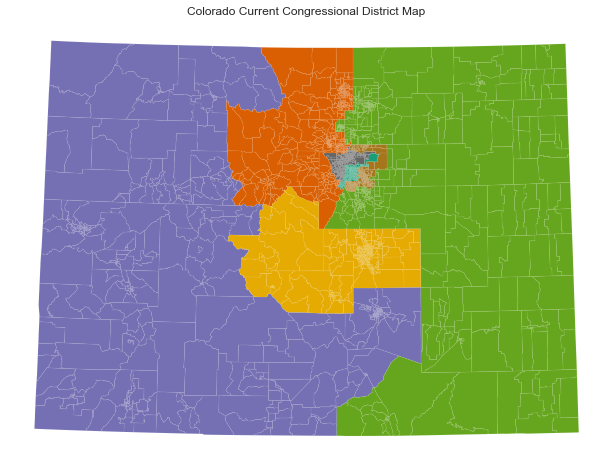

In [4]:
uf.plot_district_map(df_mggg, 
                     df_mggg['CD116FP'].to_dict(), 
                     title="Colorado Current Congressional District Map", 
                     map_colors="Dark2")

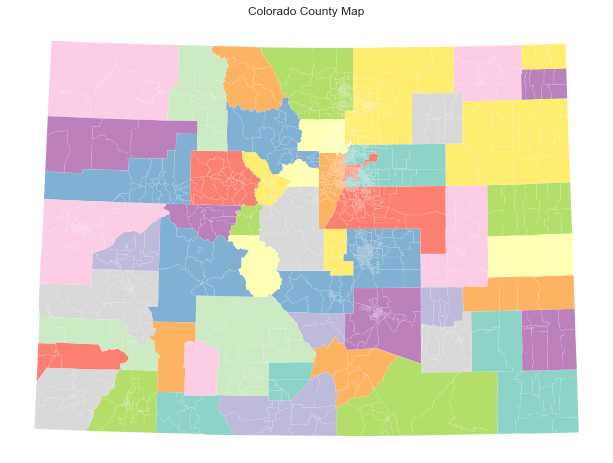

In [5]:
uf.plot_district_map(df_mggg, 
                     df_mggg['COUNTYFP'].to_dict(), 
                     title="Colorado County Map", 
                     map_colors="Set3")

Visualize Colorado dual graph


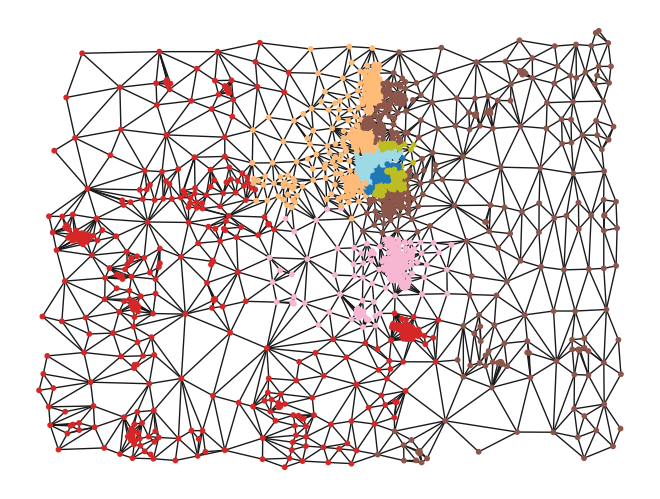

In [295]:
print("Visualize Colorado dual graph")

nx.draw(graph_mggg,pos = {node:(graph_mggg.nodes[node]["C_X"],graph_mggg.nodes[node]["C_Y"]) 
                     for node in graph_mggg.nodes()},node_color=[graph_mggg.nodes[node]["CD116FP"] 
                                                            for node in graph_mggg.nodes()],node_size=10,cmap='tab20')

# Metric Selection

*Decision Point*: Which metrics are most appriopriate for my analysis?

Our Colorado analysis specifically focuses on political competitiveness, particularly in relationship to the hierarchy of redistricting rules criteria. We made this decision based on the diverse set of states within our project, deciding what value each state context can bring to our stakeholder guide. 

There are multiple ways to define what is political competitiveness, and the literature is not united on the best way to capture electoral competition. Indeed, there are many complicated factors that contribute to what makes an election competitive: candidate spending, incumbency effect, as well as district boundaries and previous election results. We have provided a curated reading list in Section 3.2: Colorado Case Study of our stakeholder guide.

After reviewing the literature and examining field-specific consensus, we decided to focus our definition of political competitiveness through the vote band method. [Clelland et al. (2021)](https://arxiv.org/pdf/2011.06049.pdf) and [DeFord et al. (2020)](https://www.tandfonline.com/doi/pdf/10.1080/2330443X.2020.1777915) both investigate political competitiveness using GerryChain, and conclude that a vote band of 45-55% is the simplest starting point. The vote band method has also been adopted by other organizations such as the [538’s Redistricting Tracker](https://fivethirtyeight.com/features/how-fivethirtyeights-redistricting-tracker-works/) and [Princeton Gerrymandering Project’s Report Card](https://gerrymander.princeton.edu/redistricting-report-card/) (Note: the Princeton Gerrymandering Project uses a narrower band of 46.5-53.5%).

We also include county splits to our analysis to add additional nuance to our analysis of political competitiveness. 

*Limitations*: Our analysis only focuses on two rules from Colorado's hierarchy of criteria. Due to project time constraints, we didn't complete a full application of the compactness rule since the choice of compactness there would necessitate its own in-depth analysis. We encourage GerryChain modelers to consider the entire hierarchy of criteria in their state's redistricting rules and to document their decision points to highlight the trade-offs at each.

### VRA and People of Color (POC) Voting Age Population 

Before building our GerryChain file and diving into political competitiveness and county splits, we also conducted an exploratory look at the POC voting age population of Colorado. The Hispanic voting age population constitutes the largest racial minority group in Colorado, followed by the Black voting age population, and the Asian voting age population.

In [7]:
print("Hispanic Voting Age Population:", "{:.2f}".format((df_mggg["HVAP"].sum())/(df_mggg["VAP"].sum())))
print("Black Voting Age Population:", "{:.2f}".format((df_mggg["BVAP"].sum())/(df_mggg["VAP"].sum())))
print("Asian Voting Age Population:", "{:.2f}".format((df_mggg["ASIANVAP"].sum())/(df_mggg["VAP"].sum())))

df_mggg["POC_VAP"] = (df_mggg["HVAP"] + df_mggg["BVAP"] + df_mggg["AMINVAP"] + df_mggg["ASIANVAP"] 
 + df_mggg["NHPIVAP"] + df_mggg["OTHERVAP"] + df_mggg["OTHERVAP"])

df_mggg["POC_VAP_PCT"] = df_mggg["POC_VAP"]/df_mggg["VAP"]


Hispanic Voting Age Population: 0.17
Black Voting Age Population: 0.04
Asian Voting Age Population: 0.03


In [8]:
print("White Voting Age Population:", "{:.2f}".format(df_mggg["WVAP"].sum()/df_mggg["VAP"].sum())) 
print("POC Voting Age Population:", "{:.2f}".format(df_mggg["POC_VAP"].sum() / df_mggg["VAP"].sum()))

White Voting Age Population: 0.74
POC Voting Age Population: 0.25


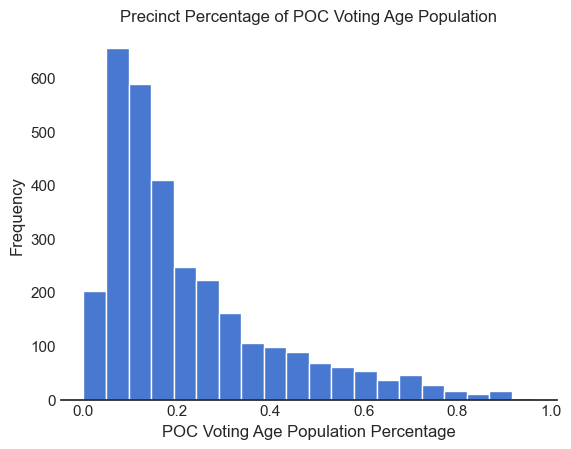

In [419]:
plt.hist(df_mggg['POC_VAP_PCT'], bins=20)
plt.title("Precinct Percentage of POC Voting Age Population")
plt.xlabel("POC Voting Age Population Percentage")
plt.ylabel("Frequency")
sns.despine(left=True, right=True)

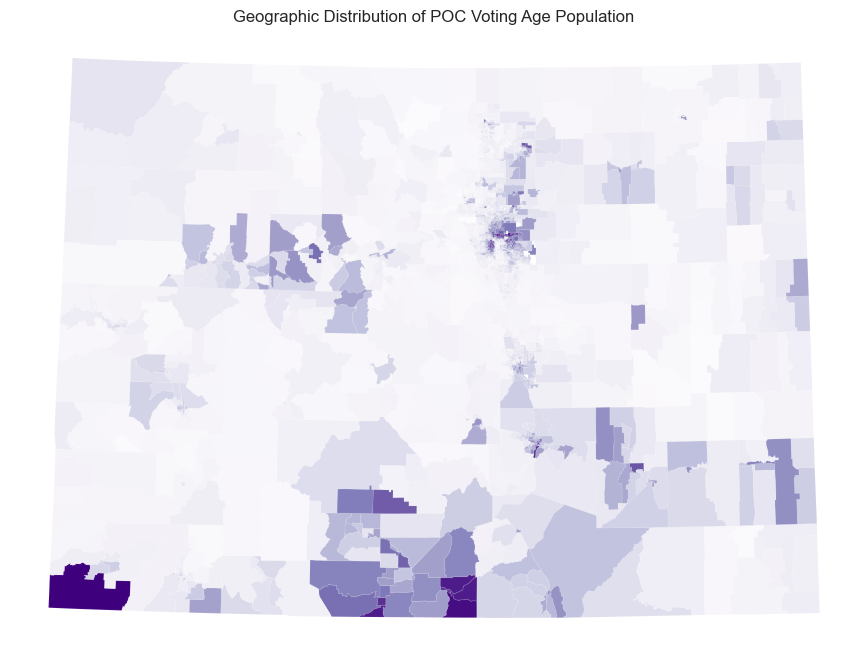

In [356]:
uf.plot_district_map(df_mggg, 
                     df_mggg['POC_VAP_PCT'].to_dict(), 
                     title="Geographic Distribution of POC Voting Age Population",
                     map_colors="Purples")

In [ ]:
for node in graph_mggg.nodes():
    graph_mggg.nodes[node]["POC_VAP"] = (graph_mggg.nodes[node]["HVAP"] + graph_mggg.nodes[node]["BVAP"] 
                                    + graph_mggg.nodes[node]["AMINVAP"] + graph_mggg.nodes[node]["ASIANVAP"] 
                                    + graph_mggg.nodes[node]["NHPIVAP"] + graph_mggg.nodes[node]["OTHERVAP"] 
                                    + graph_mggg.nodes[node]["OTHERVAP"])
    graph_mggg.nodes[node]["nPOC_VAP"] = graph_mggg.nodes[node]["VAP"] - graph_mggg.nodes[node]["POC_VAP"]

The largest concentration of POC voting age population lies in the 2012 map's large most western congressional district (District 3). 

In [11]:
state_abbr="CO"
housen="CON"
num_districts=7
pop_col="TOTPOP"
num_elections= 6

def num_splits(partition, df=df_mggg):
    df["current"] = df.index.map(partition.assignment)
    return sum(df.groupby('COUNTYFP')['current'].nunique() > 1)

updater = {
    "population": updaters.Tally("TOTPOP", alias="population"), 
    "cut_edges": cut_edges,
    "count_splits": num_splits
            }

election_names=[
    "POC_VAP", 
    "USH18", 
    "GOV18", 
    "AG18", 
    "SOS18", 
    "TRE18"
    ]

election_columns=[
    ["POC_VAP", "nPOC_VAP"], 
    ["USH18D", "USH18R"], 
    ["GOV18D", "GOV18R"], 
    ["AG18D", "AG18R"], 
    ["SOS18D", "SOS18R"], 
    ["TRE18D", "TRE18R"]
    ]

elections = [
    Election(
        election_names[i], 
        {"First": election_columns[i][0], "Second": election_columns[i][1]},
    )
    for i in range(num_elections)
]

election_updaters = {election.name: election for election in elections}
updater.update(election_updaters)

totpop = df_mggg.TOTPOP.sum()

At this point, we want to look at the baseline statistics of the 2012 Colorado enacted Congressional district plan. Here we create a dataframe that generate four metrics of interest: efficiency gap, mean-median score, number of Democratic party wins, and number of districts that could be considered competitive.

In [12]:
plan_2012 = Partition(graph_mggg,
                      df_mggg["CD116FP"],
                      updater)

plan_2012_stats = uf.export_election_metrics_per_partition(plan_2012)

plan_2012_stats = plan_2012_stats.drop(labels="POC_VAP", axis=0)
plan_2012_stats = plan_2012_stats.rename({'wins':'dem_wins'}, axis=1)

plan_2012_names = plan_2012_stats.index.values
plan_2012_comp=[]
for n in range(5):
    plan_2012_comp.append(sum([.45<x<.55 for x in plan_2012[plan_2012_names[n]].percents('First')]))

plan_2012_stats['comp_dist'] = np.array(plan_2012_comp)

plan_2012_stats

,percent,efficiency_gap,mean_median,dem_wins,comp_dist
USH18,"(0.7620680507658154, 0.5579114187509663, 0.393...",-0.021520,0.007573,4,1
GOV18,"(0.7550250594242573, 0.5617245527618341, 0.397...",-0.017109,0.012444,4,1
AG18,"(0.7370862552790284, 0.5334206800363475, 0.378...",0.025778,0.005783,4,2
SOS18,"(0.7337444396712997, 0.5506415939806384, 0.398...",0.010094,0.014931,4,1
TRE18,"(0.732847922200158, 0.547696059594734, 0.39421...",0.017570,0.015233,4,2


As previously noted, we categorize districts as politically competitive if the vote share fall within a 45-55% vote band. Our current shapefile contains results for four 2018 state-level elections and one 2018 federal election. The US House election saw one district that fell within the 45-55% vote band, while the state-level elections had two races (2018 Governor and Secretary of State) with one district considered competitive and two races (Attorney General and State Treasurer) with two districts considered competitive. The use of state-level elections is simply to note voting behavior within a district. Ultimately since we're building a proposed Congressional district map, we'll move forward in our GerryChain analysis with the 2018 US House Election data.

In [13]:
print("Number of districts with election results within the 45-55% vote band")
print("----")
print("2018 US House Election:", plan_2012_stats.loc["USH18"]["comp_dist"])
print("2018 Colorado Governor Election:", plan_2012_stats.loc["GOV18"]["comp_dist"])
print("2018 Colorado Attorney General Election:", plan_2012_stats.loc["AG18"]["comp_dist"])
print("2018 Colorado Secretary of State Election:", plan_2012_stats.loc["SOS18"]["comp_dist"])
print("2018 Colorado State Treasurer Election:", plan_2012_stats.loc["TRE18"]["comp_dist"])

Number of districts with election results within the 45-55% vote band
----
2018 US House Election: 1
2018 Colorado Governor Election: 1
2018 Colorado Attorney General Election: 2
2018 Colorado Secretary of State Election: 1
2018 Colorado State Treasurer Election: 2


We are also interested in county splits, so we count the number of county splits within the 2012 enacted plan.

In [14]:
print("The 2012 enacted plan contained", plan_2012["count_splits"], "county splits out of 64 total counties.")
print("{:.0f}".format(((plan_2012["count_splits"]/64)*100)), "% of counties were split in the 2012 enacted plan.")

The 2012 enacted plan contained 7 county splits out of 64 total counties.
11 % of counties were split in the 2012 enacted plan.


# Seed Plan Selection

*Decision Point*: Will you use an existing/enacted map or a random one?

While we should consider the appropriate starting plan to begin the ensemble, it's important to note that with enough steps, the Markov chain will reach a steady state distribution and the starting plan will not matter. However, this section will outline the different types of seed plans available in GerryChain, and how one can explore these different options.

There are two general options for a seed plan:
- *Colorado's 2012 Enacted Plan*: This will provide us with a real-world actual plan that survived the political process and has been in use for the past decade. However, it's important to note the limitations with enacted maps. In particular, a [the 2011 proposed map was challenged in court](https://ballotpedia.org/Redistricting_in_Colorado_after_the_2010_census#Legal_issues) by both the Democratic and Republican parties, and users should be familiar with the arguments and performance of previous enacted plans. 
- *Neutral Random Seed Plan*: GerryChain allows for the generation of neutral seed plans using [a variety of spanning tree methods](https://gerrychain.readthedocs.io/en/latest/api.html#spanning-tree-methods). 

First, let's generate 100 seed plans and visualize the number of county splits and competitive districts for each of these starting maps. Recall that the 2012 enacted plan had 7 county splits and the 2018 US House Election had 1 competitive district out of 7.

In [15]:
seeds_county=[]
seeds_comp=[]

#Running multiple seeds to note comp districts and county splits of starting plans
for n in range(100):
    plan_seed = recursive_tree_part(graph_mggg, #graph object
                                    range(num_districts), #how many districts
                                    totpop/num_districts, #population target
                                    "TOTPOP", #population column, variable name
                                    .01, #epsilon value
                                    1)
    
    partition_seed = Partition(graph_mggg,
                           plan_seed, 
                           updater)
    
    seeds_county.append(partition_seed["count_splits"])
    seeds_comp.append(sum([.45<x<.55 for x in partition_seed['USH18'].percents('First')]))

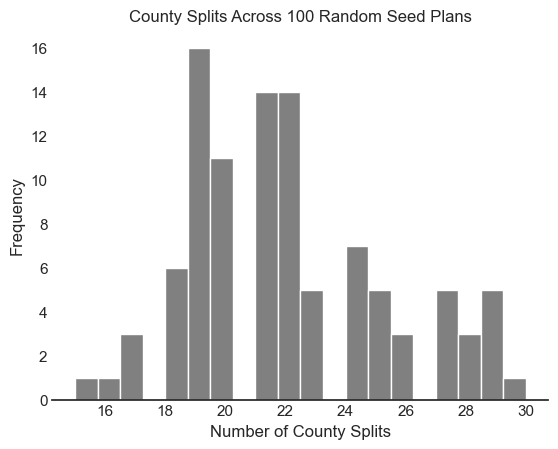

In [439]:
plt.hist(seeds_county, color="gray", bins=20)
plt.locator_params(axis="both", integer=True, tight=True)
plt.title("County Splits Across 100 Random Seed Plans")
plt.xlabel("Number of County Splits")
plt.ylabel("Frequency")
sns.despine(left=True, right=True)

In [393]:
print("The min count of county splits is", min(seeds_county))
print("The max count of county splits is", max(seeds_county))

The min count of county splits is 15
The max count of county splits is 30


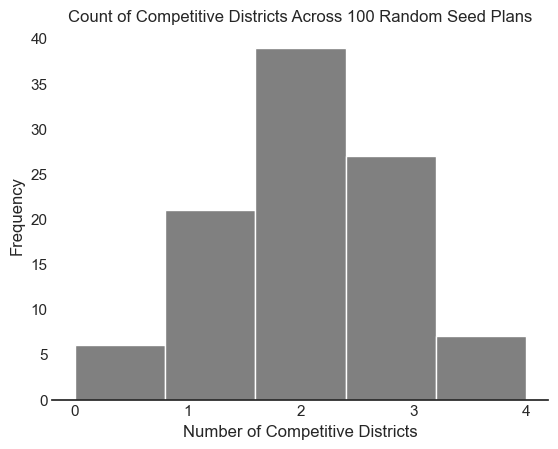

In [440]:
plt.hist(seeds_comp, color="gray", bins=5)
plt.locator_params(axis="both", integer=True, tight=True)
plt.title("Count of Competitive Districts Across 100 Random Seed Plans")
plt.xlabel("Number of Competitive Districts")
plt.ylabel("Frequency")
sns.despine(left=True, right=True)

In [395]:
print("The min count of competitive districts is", min(seeds_comp))
print("The max count of competitive districts is", max(seeds_comp))

The min count of competitive districts is 0
The max count of competitive districts is 4


Results show that out of 100 randomly generated neutral seed plans, the maps have more county splits than the 2012 enacted plan, while the number of competitive districts run the range from 0 to 4 with a mean of 2 districts out of 7 total. 

# Proposal Selection

*Decision Point*: Is Flip or ReCombination (ReCom) more appropriate?

GerryChain has [four specific proposals](https://gerrychain.readthedocs.io/en/latest/api.html?highlight=proposals#module-gerrychain.proposals) that can be applied to the Markov chain. These proposals fall into the two types: Flip and the ReCombination (ReCom) proposals. Additional reading on how to apply ReCom can be found in [MGGG's Virginia House of Delegates Report](https://mggg.org/VA-report.pdf) and the [GerryChain guide](https://gerrychain.readthedocs.io/en/latest/user/recom.html). A detailed report describing the merits between Flip and ReCom proposals can be found in a [2021 report published at the Harvard Data Science Review](https://hdsr.mitpress.mit.edu/pub/1ds8ptxu/release/4).

This section demonstrates the different performance of four combinations of seed plans and proposals, and we conduct analyses comparing starting plans and different Markov chain types. For starting plans, we consider (1.) a random "neutral" seed plan generated from a recursive tree partition and (2.) the 2012 Colorado plan. For chain types we considered (a.) a flip boundary walk and (b.) a ReCom walk. Here, we can compare if the starting plan matters and if the type of Markov chain matters.

In [37]:
plan_neutral = recursive_tree_part(graph_mggg, 
                                   range(num_districts), 
                                   totpop/num_districts, 
                                   "TOTPOP", 
                                   .01, 
                                   1)

partition_neutral = Partition(graph_mggg,
                              plan_neutral, 
                              updater)

partition_enacted_2012 = Partition(graph_mggg,
                                   df_mggg["CD116FP"],
                                   updater)

In [38]:
ideal_population = sum(partition_neutral["population"].values()) / len(partition_neutral)

popbound = constraints.within_percent_of_ideal_population(partition_neutral, 0.01)

compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 1.5 * len(partition_neutral["cut_edges"])
)

In [39]:
recom_proposal = partial(
    recom,
    pop_col="TOTPOP",
    pop_target=ideal_population,
    epsilon=0.01,
    node_repeats=1,
    method=bipartition_tree_random
)

In [40]:
steps_num = 1000

chain_2012_flip = MarkovChain(
    proposal=propose_random_flip,
    constraints=[
        popbound,
        compactness_bound,
        constraints.single_flip_contiguous
    ],
    accept=accept.always_accept, 
    initial_state=partition_enacted_2012,
    total_steps=steps_num*10
)

chain_2012_recom = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=accept.always_accept, 
    initial_state=partition_enacted_2012,
    total_steps=steps_num
)

chain_seed_flip = MarkovChain(
    proposal=propose_random_flip,
    constraints=[
        popbound,
        compactness_bound,
        constraints.single_flip_contiguous
    ],
    accept=accept.always_accept, 
    initial_state=partition_neutral,
    total_steps=steps_num*10
)

chain_seed_recom = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=accept.always_accept, 
    initial_state=partition_neutral,
    total_steps=steps_num
)

In [41]:
chain_dict = {
              'flip_2012': chain_2012_flip,
              'recom_2012': chain_2012_recom,
              'flip_seed': chain_seed_flip,
              'recom_seed': chain_seed_recom,
             }

per_chain = {chain_name: {} for chain_name in chain_dict.keys()}

for name, chain in chain_dict.items():
    print(name)
    count_county=[]
    count_comp=[]
    for part in chain:
        count_county.append(part["count_splits"])
        count_comp.append(sum([.45<x<.55 for x in part['USH18'].percents('First')]))
    per_chain[name]['county_splits'] = np.array(count_county)
    per_chain[name]['comp_dist'] = np.array(count_comp)

flip_2012
recom_2012
flip_seed
recom_seed


In [42]:
pc_keys = list(per_chain.keys())

df_county_split = pd.DataFrame(columns=pc_keys)
df_comp_dist = pd.DataFrame(columns=pc_keys)

for n in range(4):
    df_county_split[pc_keys[n]] = pd.Series(per_chain[pc_keys[n]]["county_splits"])
    df_comp_dist[pc_keys[n]] = pd.Series(per_chain[pc_keys[n]]["comp_dist"])

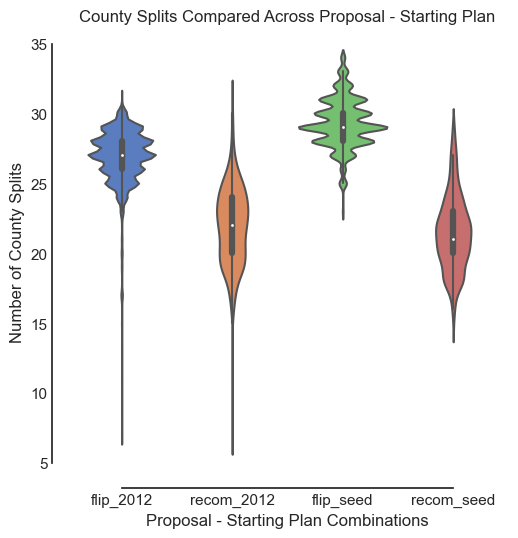

In [388]:
sns.catplot(data= df_county_split[["flip_2012",
                                     "recom_2012",
                                     "flip_seed",
                                     "recom_seed"]],
               kind="violin")
plt.title("County Splits Compared Across Proposal - Starting Plan")
plt.xlabel("Proposal - Starting Plan Combinations")
plt.ylabel("Number of County Splits")
sns.despine(offset=10, trim=True)

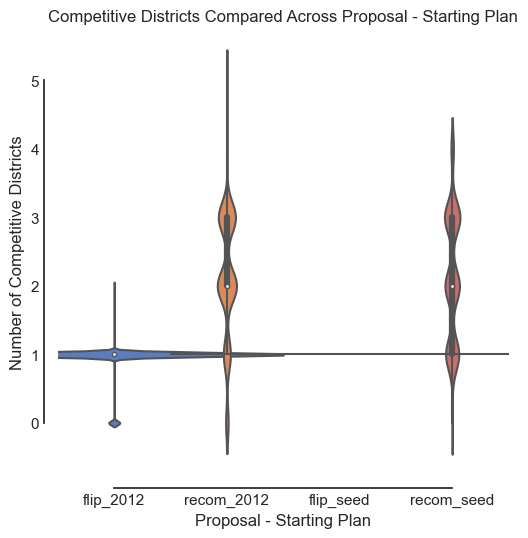

In [387]:
sns.catplot(data= df_comp_dist[["flip_2012",
                                   "recom_2012",
                                   "flip_seed",
                                   "recom_seed"]],
           kind="violin",
           width=3)
plt.title("Competitive Districts Compared Across Proposal - Starting Plan")
plt.xlabel("Proposal - Starting Plan")
plt.ylabel("Number of Competitive Districts")
sns.despine(offset=10, trim=True)

While we only ran the Markov chain for 1,000 ReCom steps and 10,000 Flip steps – which are not enough steps to reach a steady state distribution – we can note that choice of starting plan doesn't matter as much as the proposal type. The ReCom proposals explore a far greater range of potential plans for both county splits and competitive districts. For the rest of our analysis, we will use the ReCom proposal with a 2012 starting plan.

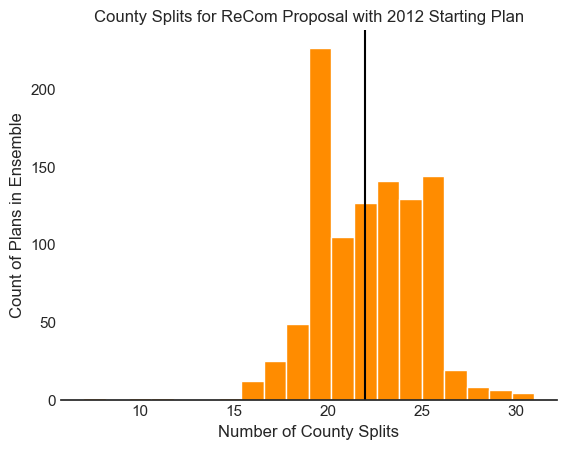

In [441]:
plt.hist(per_chain["recom_2012"]["county_splits"], color="darkorange", bins=20)
plt.axvline(x=(per_chain["recom_2012"]["county_splits"]).mean(),
           color="black")
plt.locator_params(axis="both", integer=True, tight=True)
plt.title("County Splits for ReCom Proposal with 2012 Starting Plan")
plt.xlabel("Number of County Splits")
plt.ylabel("Count of Plans in Ensemble")
sns.despine(left=True, right=True)

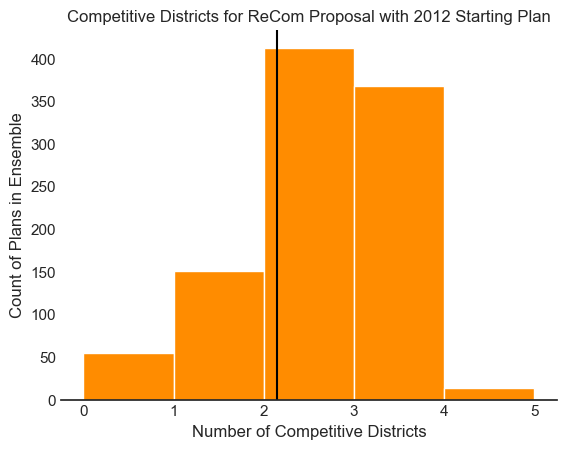

In [442]:
plt.hist(per_chain["recom_2012"]["comp_dist"], color="darkorange", bins=5)
plt.axvline(x=(per_chain["recom_2012"]["comp_dist"]).mean(),
           color="black")
plt.locator_params(axis="both", integer=True, tight=True)
plt.title("Competitive Districts for ReCom Proposal with 2012 Starting Plan")
plt.xlabel("Number of Competitive Districts")
plt.ylabel("Count of Plans in Ensemble")
sns.despine(left=True, right=True)

# Constraints

*Decision Point*: Which contraints are most important in your state?

Based on the Colorado hierarchy of criteria, our constraints are focused on population balance and compactness. We relegate the preservation of county lines and political competitiveness to acceptance functions since we seek more flexibility in those rules.

We use a basic population bound constraints available in GerryChain as well as a generic compactness bound constraint. As detailed at the top of this notebook, compactness is a non-trivial consideration and would require in-depth analysis to consider which compactness measure to ultimately use.

*Limitations*: We intentionally bounded our efforts for this case study to not address compactness measures. Users interested in a more in-depth study of Colorado should consider the trade-offs associated with quantifying a specific measure of compactness and incorporating it into a compactness bound constraint. 

In [48]:
popbound = constraints.within_percent_of_ideal_population(partition_neutral, 0.01)

In [49]:
compactness_bound = constraints.UpperBound(
    lambda p: len(p["cut_edges"]), 1.5 * len(partition_neutral["cut_edges"])
)

# Acceptance Functions

*Decision Point*: Which acceptance functions will you prioritize?

We previously highlighted that there are many different ways to think about political competitiveness. And even though we selected the most straight forward and direct definition of political competitiveness – a 45-55% vote band – there are multiple ways to write an acceptance function to coerce the Markov chain to explore maps that maximize the number of districts that fall in that band.

Recall that we also hope to minimize county splits for proposed plans. The 2012 enacted plan had 7 county splits, which is far fewer than the ReCom proposal results generated when we compared proposal-seed combinations. If we hope to extend GerryChain analysis to real-world situations, it would be prudent to consider baseline qualities in the most recent map of interest and consider those important traits to include in proposed plans.

This section details four different custom acceptance functions specific to the Colorado context. We present these options as illustrative examples on how to write custom acceptance functions and the decisions necessary for modeling.

- *Competitive Accept*: This acceptance function only accepts the next step of a chain if it has the same or more count of districts that fall within the 45-55% vote band. 
- *Competitive Nudge Accept*: This acceptance function attempts to "nudge" districts that are close to the 45-55% vote band into the band. It does this by coercing the chain to increase the number of districts that fall within a 40-60% vote share band, and then accepts next steps of a chain that has the same or more count of districts that fall within the 45-55% vote band.
- *Competitive County Accept*: This acceptance function uses the Competitive Accept function and adds a condition that to minimize county splits. Specifically it will only accept the next step of a chain if it has fewer county splits than the previous step. 
- *Competitive Nudge County Accept*: This acceptance function uses the Competitive Nudge Accept function and adds a condition that to minimize county splits. Specifically it will only accept the next step of a chain if it has fewer county splits than the previous step. 

Each of the four acceptance functions include a 10% degree of randomness in the function to ensure the Markov chain explores different configurations of the state space. This value is intentionally kept low since our ambitions for the chain is to minimize and maximize specific conditions. 

In [100]:
def competitive_accept(partition):
    new_score = 0 
    old_score = 0 
    
    for i in range(7):
        if .45 < partition.parent['USH18'].percents("First")[i] <.55:
            old_score += 1
            
        if .45 < partition['USH18'].percents("First")[i] <.55:
            new_score += 1
            
    if (new_score >= old_score):
        return True
    
    elif (random.random() < .10):
        return True
    
    else:
        return False

In [101]:
def competitive_nudge_accept(partition):
    nudge_old = 0 
    nudge_new = 0 
    
    for i in range(7):
        if .40 < partition.parent['USH18'].percents("First")[i] <.60:
            nudge_old += 1
            
        if .40 < partition['USH18'].percents("First")[i] <.60:
            nudge_new += 1
    
    band_old = 0 
    band_new = 0 
    
    for i in range(7):
        if .45 < partition.parent['USH18'].percents("First")[i] <.55:
            band_old += 1
            
        if .45 < partition['USH18'].percents("First")[i] <.55:
            band_new += 1
            
    if (nudge_new >= nudge_old) and (band_new >= band_old):
        return True
    
    elif (band_new >= band_old):
        return True
    
    elif (random.random() < .10):
        return True
    
    else:
        return False

In [102]:
def competitive_county_accept(partition):
    new_score = 0 
    old_score = 0 
    
    for i in range(7):
        if .45 < partition.parent['USH18'].percents("First")[i] <.55:
            old_score += 1
            
        if .45 < partition['USH18'].percents("First")[i] <.55:
            new_score += 1
            
    if (new_score >= old_score) and (partition["count_splits"] < partition.parent["count_splits"]):
        return True
    
    elif (new_score >= old_score) and (random.random() < .10):
        return True
    
    elif (partition["count_splits"] < partition.parent["count_splits"]) and (random.random() < .10): 
        return True
    
    else:
        return False

In [103]:
def competitive_nudge_county_accept(partition):
    nudge_old = 0 
    nudge_new = 0 
    
    for i in range(7):
        if .40 < partition.parent['USH18'].percents("First")[i] <.60:
            nudge_old += 1
            
        if .40 < partition['USH18'].percents("First")[i] <.60:
            nudge_new += 1
    
    band_old = 0 
    band_new = 0 
    for i in range(7):
        if .45 < partition.parent['USH18'].percents("First")[i] <.55:
            band_old += 1
            
        if .45 < partition['USH18'].percents("First")[i] <.55:
            band_new += 1
            
    if (nudge_new >= nudge_old) and (band_new >= band_old) \
    and (partition["count_splits"] < partition.parent["count_splits"]):
        return True
    
    elif (band_new >= band_old) \
    and (partition["count_splits"] < partition.parent["count_splits"]):
        return True
    
    elif (nudge_new >= nudge_old) and (band_new >= band_old) \
    and (random.random() < .10):
        return True
        
    elif (random.random() < .10) \
    and (partition["count_splits"] < partition.parent["count_splits"]):
        return True
    
    else:
        return False

Here we run four different chain configurations, each for 1,000 ReCom steps using one of the custom acceptance functions.

In [104]:
acc_steps_num = 1000

acc_chain_competitive = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=competitive_accept, 
    initial_state=partition_enacted_2012,
    total_steps=acc_steps_num
)

acc_chain_competitive_nudge = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=competitive_nudge_accept, 
    initial_state=partition_enacted_2012,
    total_steps=acc_steps_num
)

acc_chain_competitive_county = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=competitive_county_accept, 
    initial_state=partition_enacted_2012,
    total_steps=acc_steps_num
)

acc_chain_competitive_nudge_county = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=competitive_nudge_county_accept, 
    initial_state=partition_enacted_2012,
    total_steps=acc_steps_num
)

In [105]:
acc_dict = {'competitive': acc_chain_competitive,
            'competitive_nudge': acc_chain_competitive_nudge,
            'competitive_county': acc_chain_competitive_county,
            'competitive_nudge_county': acc_chain_competitive_nudge_county
}

acc_per_chain = {acc_chain_name: {} for acc_chain_name in acc_dict.keys()}

t=0
for name, chain in acc_dict.items():
    print(name)
    acc_county=[]
    acc_comp=[]
    for part in chain:
        acc_county.append(part["count_splits"])
        acc_comp.append(sum([.45<x<.55 for x in part['USH18'].percents('First')]))
        t += 1
        if t % 100 == 0:
            print(t)
        if t%1000==0:
            t=0
    acc_per_chain[name]['county_splits'] = np.array(acc_county)
    acc_per_chain[name]['comp_dist'] = np.array(acc_comp)

competitive
100
200
300
400
500
600
700
800
900
1000
competitive_nudge
100
200
300
400
500
600
700
800
900
1000
competitive_county
100
200
300
400
500
600
700
800
900
1000
competitive_nudge_county
100
200
300
400
500
600
700
800
900
1000


In [106]:
acc_keys = list(acc_per_chain.keys())

df_acc_county = pd.DataFrame(columns=acc_keys)
df_acc_comp = pd.DataFrame(columns=acc_keys)

for n in range(4):
    df_acc_county[acc_keys[n]] = pd.Series(acc_per_chain[acc_keys[n]]["county_splits"])
    df_acc_comp[acc_keys[n]] = pd.Series(acc_per_chain[acc_keys[n]]["comp_dist"])

Our results demonstrate the trade-offs with each of these acceptance functions. A simple politically competitive vote band approach – accepting next steps that match or exceed the number of districts that fall within the 45-55% vote share – gives us an ensemble mean of 3 competitive districts. Adding a nudge condition – coercing the chain to shift districts into a 40-60% vote share band and then count the number of 45-55% vote share competitive districts – yields an ensemble mean of 4 competitive districts. However, just focusing on competitiveness and not county preservation wouldn't satisfy the hierarchy of redistricting rule criteria. The acceptance functions that only focus on competitiveness have more county splits compared to acceptance functions that include a county split condition. If we examine the two county-sensitive politically competitive acceptance functions, we can see that the ensemble mean for each of them is 3 districts, but the county splits are far more favorable. Here we can make a decision to proceed with the competitive nudge county acceptance function since it provides the most promise for minimizing county splits and maximizing politically competitive districts.

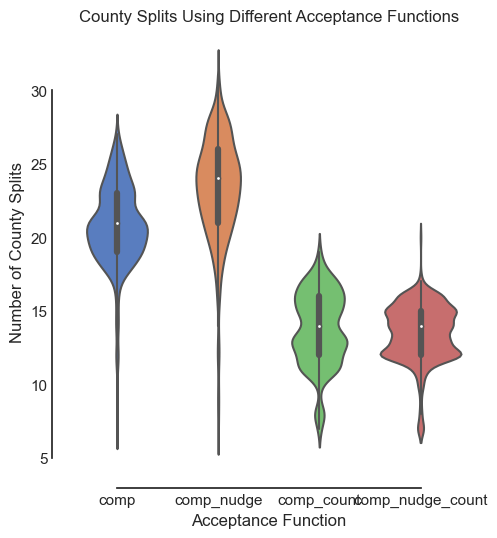

In [410]:
sns.catplot(data= df_acc_county[["competitive",
                                 "competitive_nudge",
                                 "competitive_county",
                                 "competitive_nudge_county"]],
            kind="violin")
plt.xticks(range(4), 
           ["comp", "comp_nudge", "comp_count", "comp_nudge_count"])
plt.title("County Splits Using Different Acceptance Functions")
plt.xlabel("Acceptance Function")
plt.ylabel("Number of County Splits")
sns.despine(offset=10, trim=True)

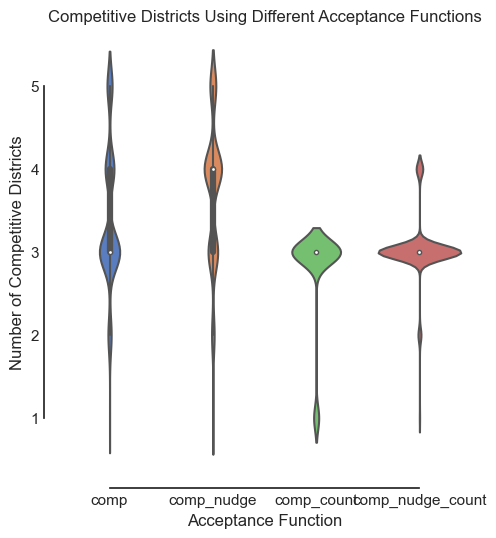

In [409]:
sns.catplot(data= df_acc_comp[["competitive",
                               "competitive_nudge",
                               "competitive_county",
                               "competitive_nudge_county"]],
            kind="violin")
plt.xticks(range(4), 
           ["comp", "comp_nudge", "comp_count", "comp_nudge_count"])
plt.title("Competitive Districts Using Different Acceptance Functions")
plt.xlabel("Acceptance Function")
plt.ylabel("Number of Competitive Districts")
sns.despine(offset=10, trim=True)

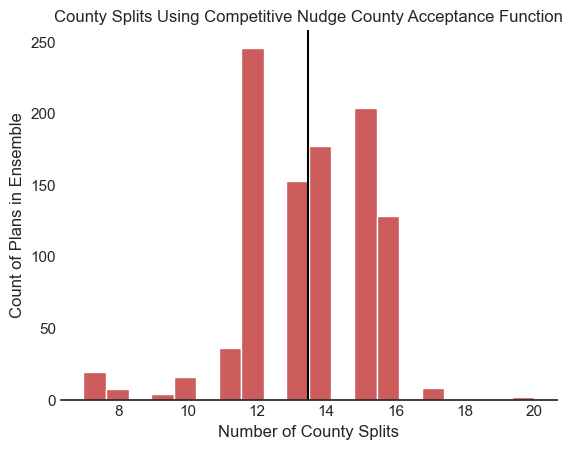

In [437]:
plt.hist(acc_per_chain["competitive_nudge_county"]["county_splits"],
        bins=20,
        color="indianred")
plt.axvline(x=(acc_per_chain["competitive_nudge_county"]["county_splits"]).mean(),
           color="black")
plt.title("County Splits Using Competitive Nudge County Acceptance Function")
plt.xlabel("Number of County Splits")
plt.ylabel("Count of Plans in Ensemble")
plt.locator_params(axis="both", integer=True, tight=True)
sns.despine(left=True, right=True)

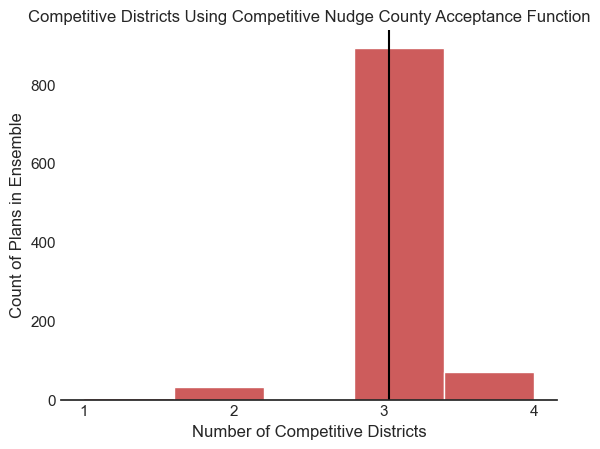

In [433]:
plt.hist(acc_per_chain["competitive_nudge_county"]["comp_dist"],
        bins=5,
        color="indianred")
plt.axvline(x=(acc_per_chain["competitive_nudge_county"]["comp_dist"]).mean(),
           color="black")
plt.title("Competitive Districts Using Competitive Nudge County Acceptance Function")
plt.xlabel("Number of Competitive Districts")
plt.ylabel("Count of Plans in Ensemble")
plt.locator_params(axis="both", integer=True, tight=True)
sns.despine(left=True, right=True)

# Number of Steps

*Decision Point* Did the chain reach convergence?

Finally, we have to make a decision on how many steps our Markov chain will take. The number of steps is reliant on the type of proposal selected; we have the benefit of [prior research](https://malmskog.files.wordpress.com/2020/08/august-9-co-ensemble-analysis.pdf) demonstrating that 20,000 ReCom steps is a promising starting point. 

However, to illustrate chain convergence, this section walks through two classes of approaches to check for chain convergence: multi-start and within chain.

- *Multi-start*: A multi-start approach will use two different starting seed plans similar to our previous section comparing different seed plans. Here we will use Colorado's 2012 enacted plan and a random "neutral" plan generated by GerryChain's recursive tree partition function. 
- *Within Chain*: A within chain approach seeks to examine the distribution of the first 10%, 50% of the run to the full distribution. It's important to stress that there's so far "no theoretical guarantees regarding the mixing time of any of these proposal methods, but this adds to the heuristic evidence raising our confidence in effective sampling" ([MGGG, 2018, p. 20](https://mggg.org/VA-report.pdf)).

First, we build two Markov Chains with different starting plans: the 2012 enacted plan and a random neutral seed plan, and run the chain for 20,000 steps. These chains utilize the contraints we detailed previously as well as the competitive nudge county acceptance function.

In [147]:
chain_2012 = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=competitive_nudge_county_accept, 
    initial_state=partition_enacted_2012,
    total_steps=20000
)

chain_neutral = MarkovChain(
    proposal=recom_proposal,
    constraints=[
        popbound,
        compactness_bound
    ],
    accept=competitive_nudge_county_accept, 
    initial_state=partition_neutral,
    total_steps=20000
)

In [148]:
converge_dict = {'chain_2012': chain_2012,
                 'chain_neutral': chain_neutral,
}

converge_per_chain = {converge_chain_name: {} for converge_chain_name in converge_dict.keys()}

t=0
for name, chain in converge_dict.items():
    print(name)
    converge_county=[]
    converge_comp=[]
    for part in chain:
        converge_county.append(part["count_splits"])
        converge_comp.append(sum([.45<x<.55 for x in part['USH18'].percents('First')]))
        t += 1
        if t % 1000 == 0:
            print(t)
        if t%20000==0:
            t=0
    converge_per_chain[name]['county_splits'] = np.array(converge_county)
    converge_per_chain[name]['comp_dist'] = np.array(converge_comp)

chain_2012
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
chain_neutral
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000


In [149]:
converge_keys = list(converge_per_chain.keys())

df_converge_county = pd.DataFrame(columns=converge_keys)
df_converge_comp = pd.DataFrame(columns=converge_keys)

for n in range(2):
    df_converge_county[converge_keys[n]] = pd.Series(converge_per_chain[converge_keys[n]]["county_splits"])
    df_converge_comp[converge_keys[n]] = pd.Series(converge_per_chain[converge_keys[n]]["comp_dist"])

**Multi-Start Approach (Between Chains)**: We can see from the two violin plots the evidence of independence of starting seed plan. 

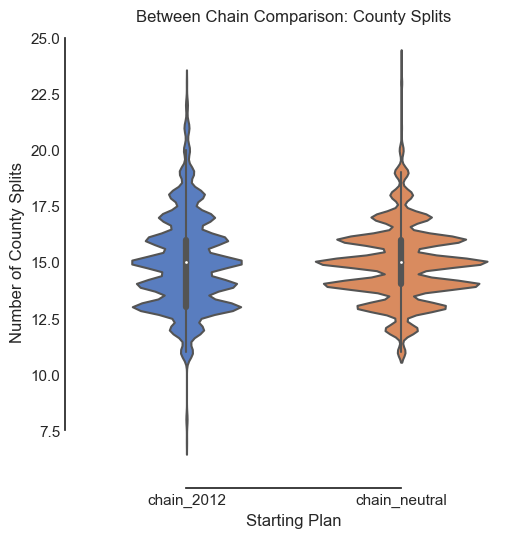

In [375]:
sns.catplot(data= df_converge_county[["chain_2012", "chain_neutral"]],
            kind="violin")
plt.title("Between Chain Comparison: County Splits")
plt.xlabel("Starting Plan")
plt.ylabel("Number of County Splits")
sns.despine(offset=10, trim=True)

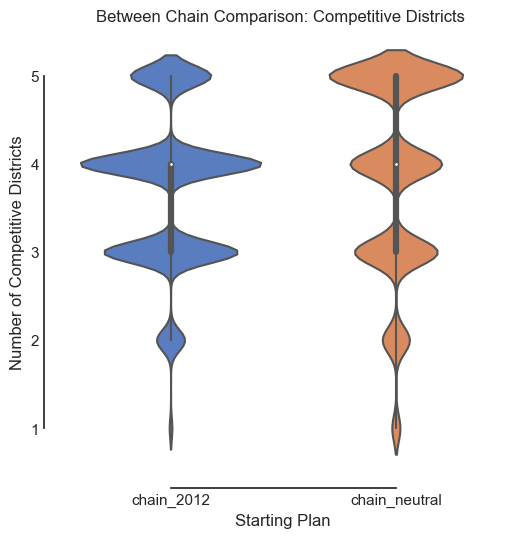

In [374]:
sns.catplot(data= df_converge_comp[["chain_2012", "chain_neutral"]],
            kind="violin")
plt.title("Between Chain Comparison: Competitive Districts ")
plt.xlabel("Starting Plan")
plt.ylabel("Number of Competitive Districts")
sns.despine(offset=10, trim=True)

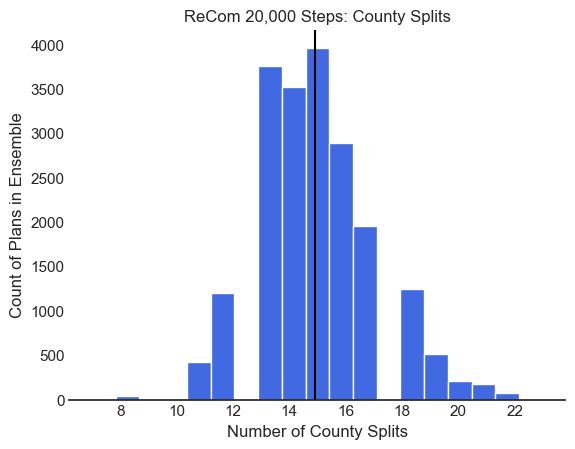

In [450]:
plt.hist(converge_per_chain["chain_2012"]["county_splits"],
         bins=19,
         color="royalblue")
plt.axvline(x=(converge_per_chain["chain_2012"]["county_splits"]).mean(),
           color="black")
plt.locator_params(axis="both", integer=True, tight=True)
plt.title("ReCom 20,000 Steps: County Splits")
plt.xlabel("Number of County Splits")
plt.ylabel("Count of Plans in Ensemble")
sns.despine(left=True, right=True)

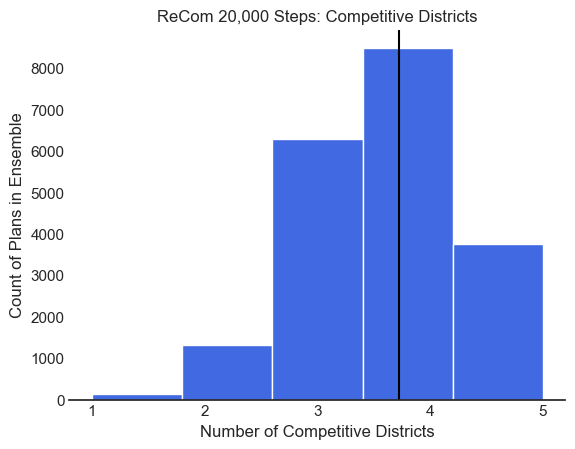

In [444]:
plt.hist(converge_per_chain["chain_2012"]["comp_dist"],
         bins=5,
         color="royalblue")
plt.axvline(x=(converge_per_chain["chain_2012"]["comp_dist"]).mean(),
           color="black")
plt.locator_params(axis="both", integer=True, tight=True)
plt.title("ReCom 20,000 Steps: Competitive Districts")
plt.xlabel("Number of Competitive Districts")
plt.ylabel("Count of Plans in Ensemble")
sns.despine(left=True, right=True)

**Within Chain Approach**: Below are two boxplots that compare the distributions of the first 10%, 50%, and 100% of the entire chain. An examination of the distribution of both county splits and competitive districts shows evidence that the chain using the ReCom proposal converged within 20,000 steps. There is minimal difference in the distributions between  10,000 steps and 20,000 steps.

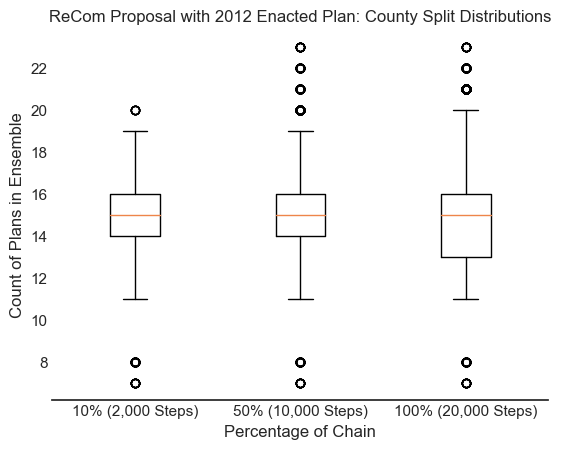

In [380]:
plt.style.use('seaborn-white')
bp_county_10 =(converge_per_chain["chain_2012"]["county_splits"][0:2000])
bp_county_50 = (converge_per_chain["chain_2012"]["county_splits"][0:10000])
bp_county_100 = (converge_per_chain["chain_2012"]["county_splits"][0:20000])
plt.boxplot([bp_county_10, bp_county_50, bp_county_100],
           labels=["10% (2,000 Steps)", "50% (10,000 Steps)", "100% (20,000 Steps)"])
plt.title("ReCom Proposal with 2012 Enacted Plan: County Split Distributions")
plt.xlabel("Percentage of Chain")
plt.ylabel("Count of Plans in Ensemble")
sns.despine(left=True, right=True)

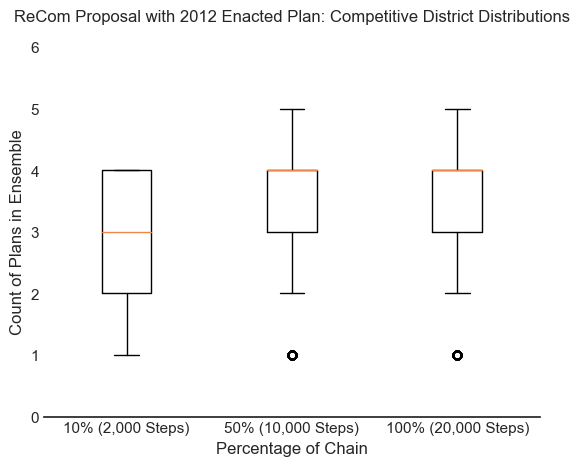

In [379]:
bp_comp_10 =(converge_per_chain["chain_2012"]["comp_dist"][0:2000])
bp_comp_50 = (converge_per_chain["chain_2012"]["comp_dist"][0:10000])
bp_comp_100 = (converge_per_chain["chain_2012"]["comp_dist"][0:20000])
plt.boxplot([bp_comp_10, bp_comp_50, bp_comp_100],
           labels=["10% (2,000 Steps)", "50% (10,000 Steps)", "100% (20,000 Steps)"])
plt.title("ReCom Proposal with 2012 Enacted Plan: Competitive District Distributions\n")
plt.yticks([0,1,2,3,4,5,6])
plt.xlabel("Percentage of Chain")
plt.ylabel("Count of Plans in Ensemble")
sns.despine(left=True, right=True)

# Modeling Decisions

Based on our EDA and modeling process, as detailed in this notebook, our final decisions are as follows:

- *Data*: 2018 U.S. House race 
- *Metrics*: Count of county splits and count of politically competitive (45-55%) districts
- *Seed Plan*: 2012 enacted plan
- *Proposal*: ReCombination 
- *Constraints*: Population bound, compactness 
- *Acceptance Function*: Minimize county splits while maximizing political competitive districts using a nudge condition
- *Number of Steps*: 20,000